In [1]:
# importing necessary libraries
import pandas as pd
import numpy as np
import json
# plotting
import matplotlib.pyplot as plt
from mplsoccer import VerticalPitch
# statistical fitting of models
import statsmodels.api as sm
import statsmodels.formula.api as smf
#opening data
import os
import pathlib
import warnings

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

#load data - store it in train dataframe
train = pd.DataFrame()
for i in range(13):
    file_name = 'events_England' + '.json'
    path = os.path.join(str(pathlib.Path().resolve().parents[0]), 'data', 'wyscout', 'events', file_name)
    with open(path) as f:
        data = json.load(f)
    train = pd.concat([train, pd.DataFrame(data)])

/var/folders/s7/mksssm8112scb6_3__pw7kb00000gq/T/ipykernel_48173/2231827044.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## xG Model

The expected goals model is built using only shots, which needs to exclude penalties. We store the coords of the shot transformed to a 105x68 pitch, and treat the centre of the goal as x=0.

The variable `C` is used to help calculate the distance and angle.  

We also need if a shot was a goal or not.

In [2]:
shots = train.loc[train['subEventName'] == "Shot"]
# get shot coords as a seperate column
shots["X"] = shots.positions.apply(lambda cell: (100 - cell[0]['x']) * 105/100)
shots["Y"] = shots.positions.apply(lambda cell: cell[0]['y'] * 68/100)
shots["C"] = shots.positions.apply(lambda cell: abs(cell[0]['y'] - 50) * 68/100)

#calculate distance and angle
shots["Distance"] = np.sqrt(shots["X"]**2 + shots["C"]**2)
shots["Angle"] = np.where(np.arctan(7.32 * shots["X"] / (shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)) > 0, np.arctan(7.32 * shots["X"] /(shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)), np.arctan(7.32 * shots["X"] /(shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)) + np.pi)
#if you ever encounter problems (like you have seen that model treats 0 as 1 and 1 as 0) while modelling - change the dependant variable to object
shots["Goal"] = shots.tags.apply(lambda x: 1 if {'id':101} in x else 0).astype(object)

## Plotting shot location

Because we want to model the relationship between shot location and goal location, first we create a heat map of all shots from 2017/18 season

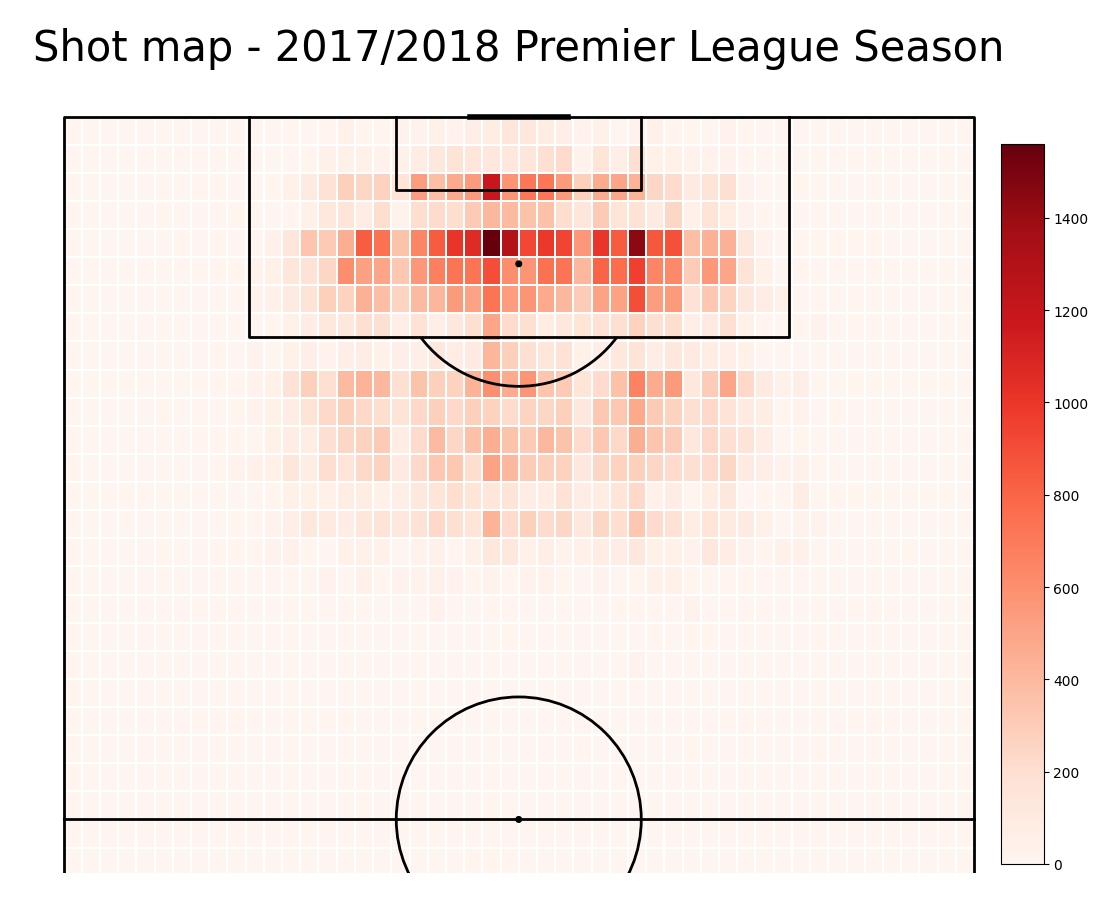

In [3]:
#plot pitch
pitch = VerticalPitch(line_color='black', half = True, pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                    endnote_height=0.04, title_space=0, endnote_space=0)
#subtracting x from 105 but not y from 68 because of inverted Wyscout axis
#calculate number of shots in each bin
bin_statistic_shots = pitch.bin_statistic(105 - shots.X, shots.Y, bins=50)
#make heatmap
pcm = pitch.heatmap(bin_statistic_shots, ax=ax["pitch"], cmap='Reds', edgecolor='white', linewidth = 0.01)
#make legend
ax_cbar = fig.add_axes((0.95, 0.05, 0.04, 0.8))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Shot map - 2017/2018 Premier League Season' , fontsize = 30)
plt.show()

Now we know where the shots were taken, we also want to know where the goals were scored from

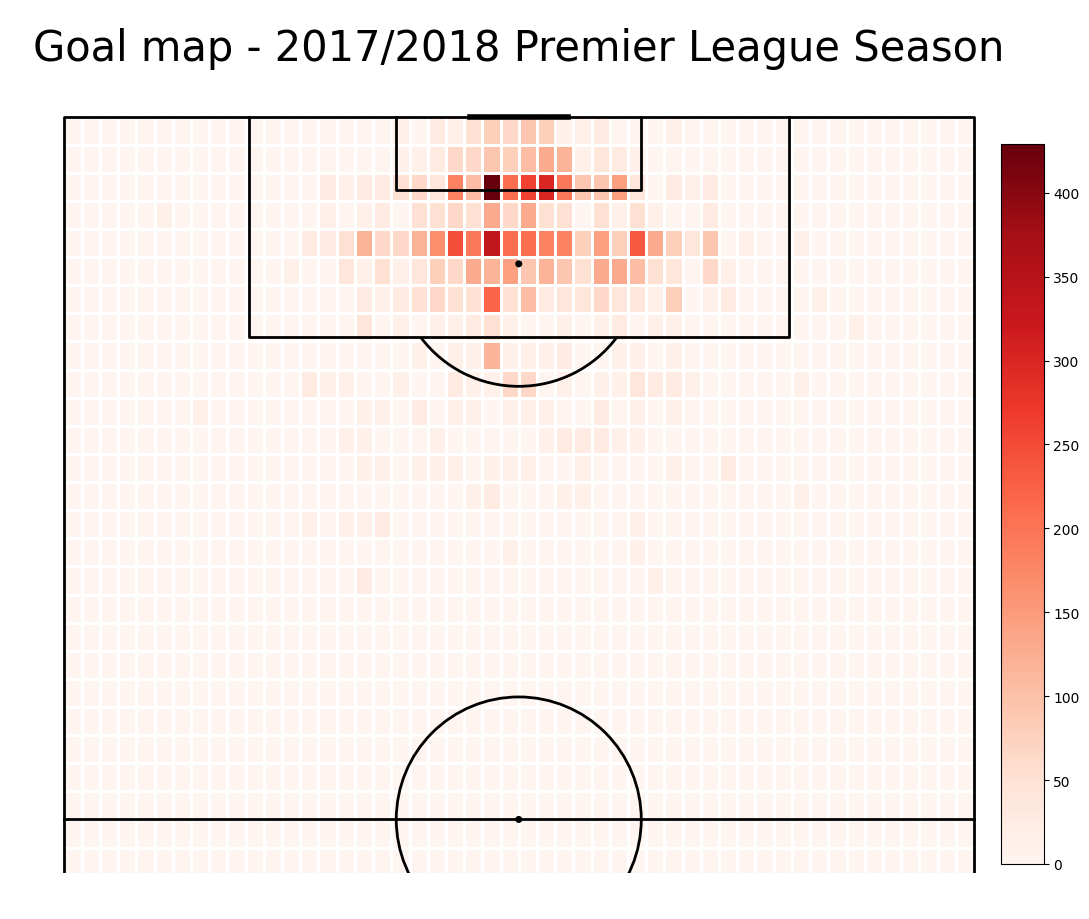

In [4]:
#take only goals
goals = shots.loc[shots["Goal"] == 1]

#plot pitch
pitch = VerticalPitch(line_color='black', half = True, pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                    endnote_height=0.04, title_space=0, endnote_space=0)

#calculate number of goals in each bin
bin_statistic_goals = pitch.bin_statistic(105 - goals.X, goals.Y, bins=50)
#plot heatmap
pcm = pitch.heatmap(bin_statistic_goals, ax=ax["pitch"], cmap='Reds', edgecolor='white')
#make legend
ax_cbar = fig.add_axes((0.95, 0.05, 0.04, 0.8))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Goal map - 2017/2018 Premier League Season' , fontsize = 30)
plt.show()

Now we can calculate the proportion of goals scored from each bin to number of shots taken from that location

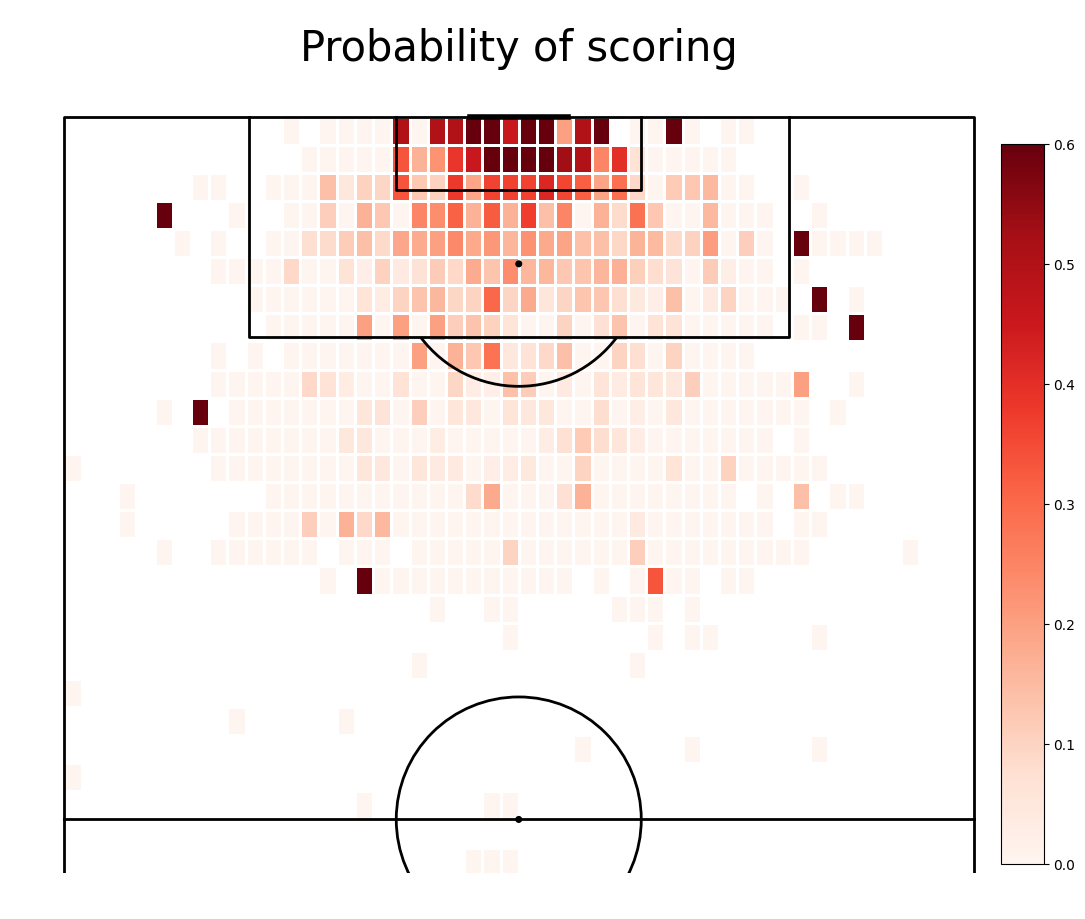

In [6]:
#plot pitch
pitch = VerticalPitch(line_color='black', half = True, pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                    endnote_height=0.04, title_space=0, endnote_space=0)
bin_statistic = pitch.bin_statistic(105 - shots.X, shots.Y, bins = 50)

#normalize number of goals by number of shots
bin_statistic["statistic"] = bin_statistic_goals["statistic"]/bin_statistic_shots["statistic"]
#plot heatmap
pcm = pitch.heatmap(bin_statistic, ax=ax["pitch"], cmap='Reds', edgecolor='white', vmin = 0, vmax = 0.6)
#make legend
ax_cbar = fig.add_axes((0.95, 0.05, 0.04, 0.8))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Probability of scoring' , fontsize = 30)
plt.show()

We use a logistic curve to fit to our model, as there is a 180 degree angle across the goal, one side being 0 degrees, 90 degree in front of goal, and 180 the other side. In front of goal, we expect a large increase in goals scored compared to either side

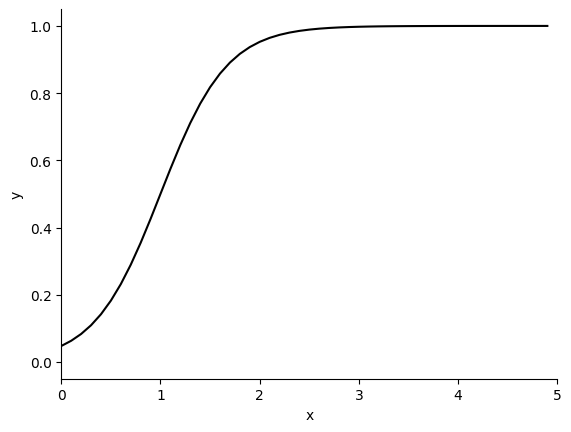

In [7]:
b = [3, -3]
x = np.arange(5, step=0.1)
y = 1/(1+np.exp(b[0]+b[1]*x))
fig,ax = plt.subplots()
plt.ylim((-0.05,1.05))
plt.xlim((0,5))
ax.set_ylabel('y')
ax.set_xlabel("x")
ax.plot(x, y, linestyle='solid', color='black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

We want to find out if angle influences scoring a goal. Lets see if a goal is scored given the angle

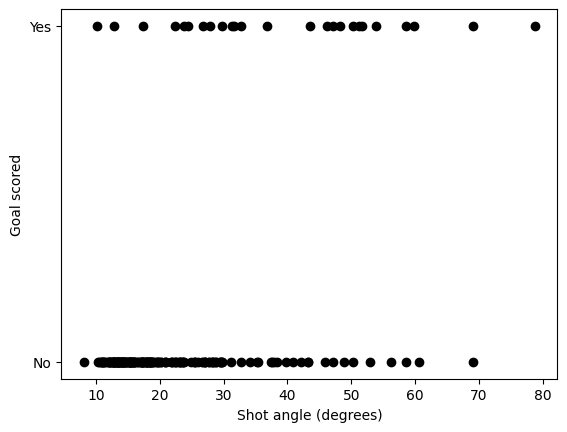

In [8]:
#first 200 shots
shots_200=shots.iloc[:200]
#plot first 200 shots goal angle
fig, ax = plt.subplots()
ax.plot(shots_200['Angle']*180/np.pi, shots_200['Goal'], linestyle='none', marker= '.', markersize= 12, color='black')
#make legend
ax.set_ylabel('Goal scored')
ax.set_xlabel("Shot angle (degrees)")
plt.ylim((-0.05,1.05))
ax.set_yticks([0,1])
ax.set_yticklabels(['No','Yes'])
plt.show()

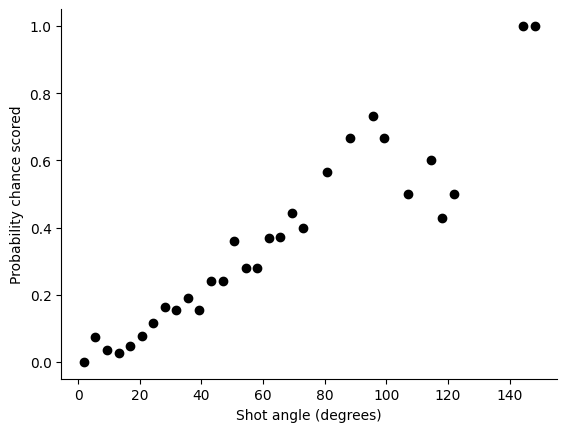

In [9]:
#number of shots from angle
shotcount_dist = np.histogram(shots['Angle']*180/np.pi, bins=40, range=[0, 150])
#number of goals from angle
goalcount_dist = np.histogram(goals['Angle']*180/np.pi, bins=40, range=[0, 150])
np.seterr(divide='ignore', invalid='ignore')
#probability of scoring goal
prob_goal = np.divide(goalcount_dist[0], shotcount_dist[0])
angle = shotcount_dist[1]
midangle = (angle[:-1] + angle[1:])/2
#make plot
fig,ax = plt.subplots()
ax.plot(midangle, prob_goal, linestyle='none', marker= '.', markersize= 12, color='black')
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Shot angle (degrees)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()